# Introduction

In this Notebook, I am working through the Income Prediction problem associated with the Adult Income Census dataset. The prediction task is to determine whether a person makes over $50K a year.

Following steps are used:

1. Load Libraries
2. Load Data
3. Very Basic Data Analysis
4. Very Basic Visualizations
5. Feature Selection + Engineering
6. Modeling + Algorithm Tuning (will use Logistic Regression, Random Forest, XGBoost & CatBoost)
7. Finalizing the Model + Prediction

### Evaluation Metric
I will be using roc_auc_score for evaluation.

This is my first Notebook, and hence, I am pretty sure there is a lot of room to improve and add ons. Please feel free to leave me any comments with regards to how I can improve.

# 1. Importing/ Loading Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

# 2. Loading Data

In [3]:
df = pd.read_csv('../../Data/adult.csv')

In [4]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Target variable : income

# 3. Analyzing Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df.shape

(32561, 15)

Let's have a look at all the categorical columns present in our dataset

In [8]:
df.select_dtypes(exclude=np.number).columns

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')

Let's have a look at all the numerical columns present in our dataset

In [9]:
df.select_dtypes(include=np.number).columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

In [10]:
# Checking for null values, if any

df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [11]:
# Checking for class imbalance

df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [12]:
# Converting the same into percentage, for better understanding

df['income'].value_counts(normalize=True)*100

<=50K    75.919044
>50K     24.080956
Name: income, dtype: float64

##### Conclusions from basic analysis of data

1. We can clearly see right off the bat that although no null values are present, there are some missing values as '?'
2. Something doesn't seem right with captial.gain, and capital.loss
3. fnlwgt seems similar to like an ID column
4. There is class imbalance. Almost 76% observations are earning less than, or equal to 50K

# 4. Visualizations

First we will visualize categorical features. Then numeric.

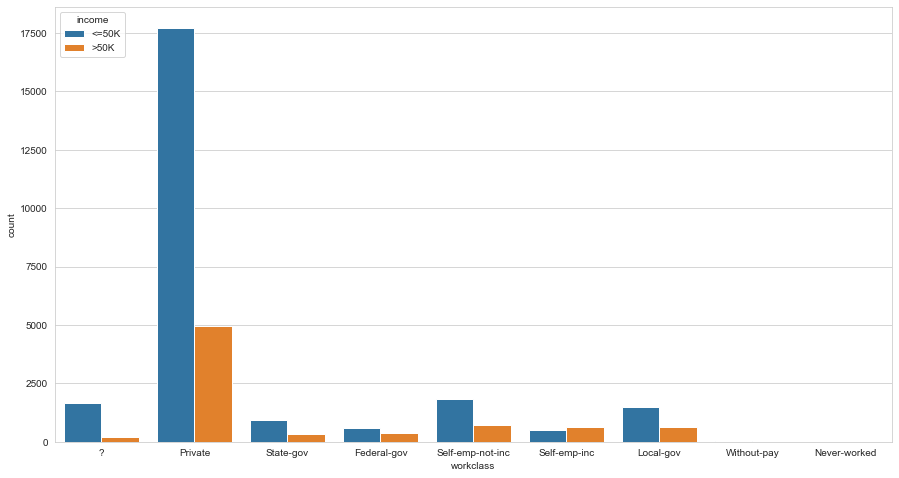

In [13]:
plt.figure(figsize=(15,8))
sns.countplot(df['workclass'], hue=df['income']);

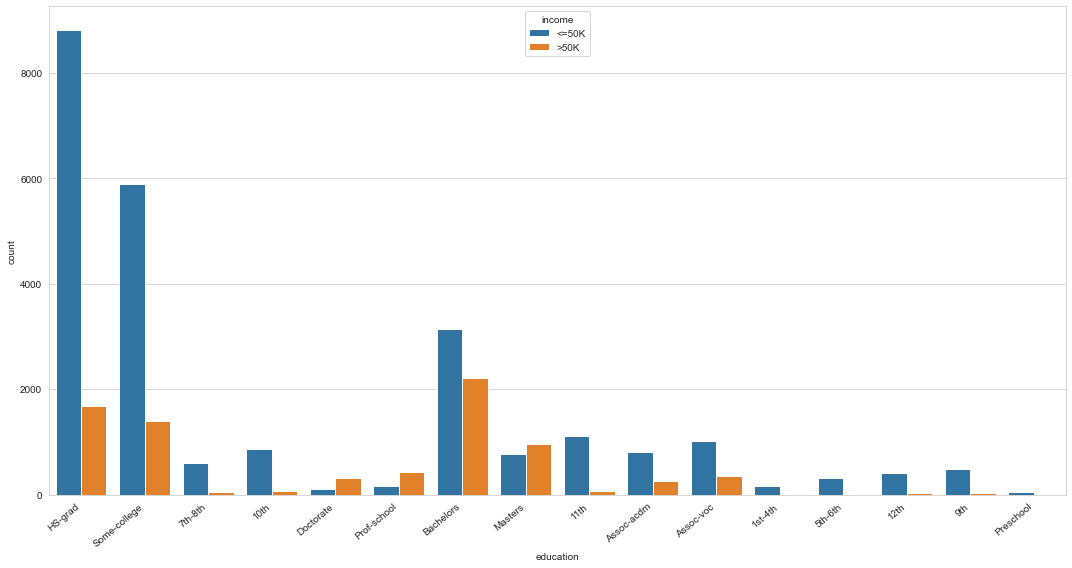

In [14]:
plt.figure(figsize=(15,8))
ax = sns.countplot(df['education'], hue=df['income']);

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

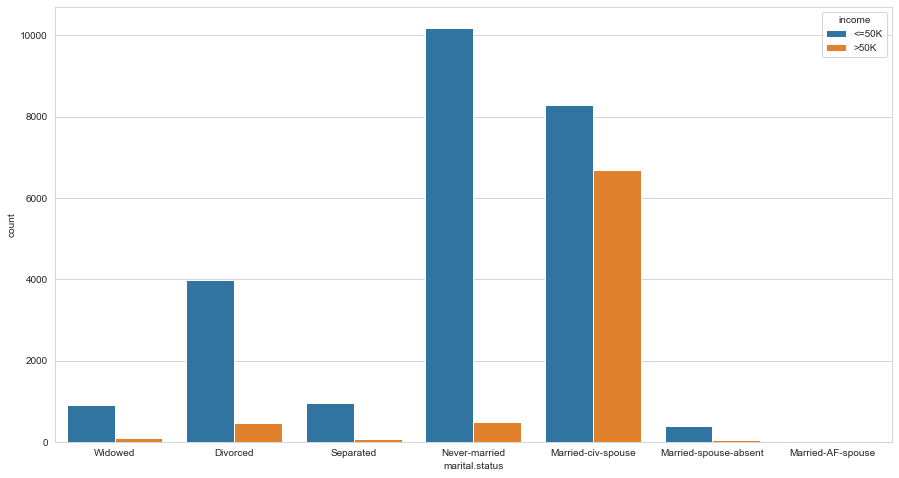

In [15]:
plt.figure(figsize=(15,8))
sns.countplot(df['marital.status'], hue=df['income']);

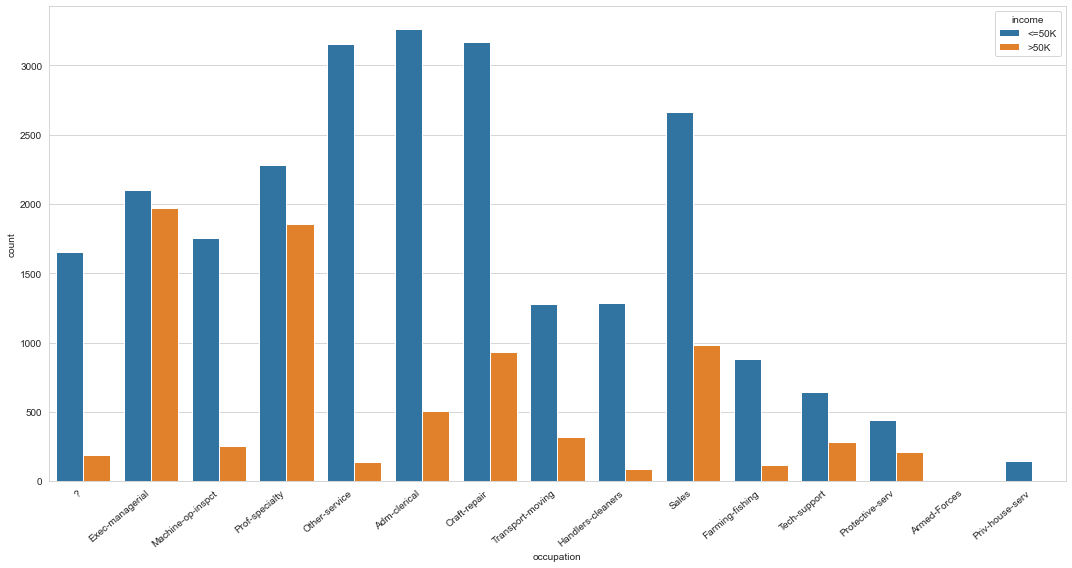

In [16]:
plt.figure(figsize=(15,8))
ax = sns.countplot(df['occupation'], hue=df['income']);

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

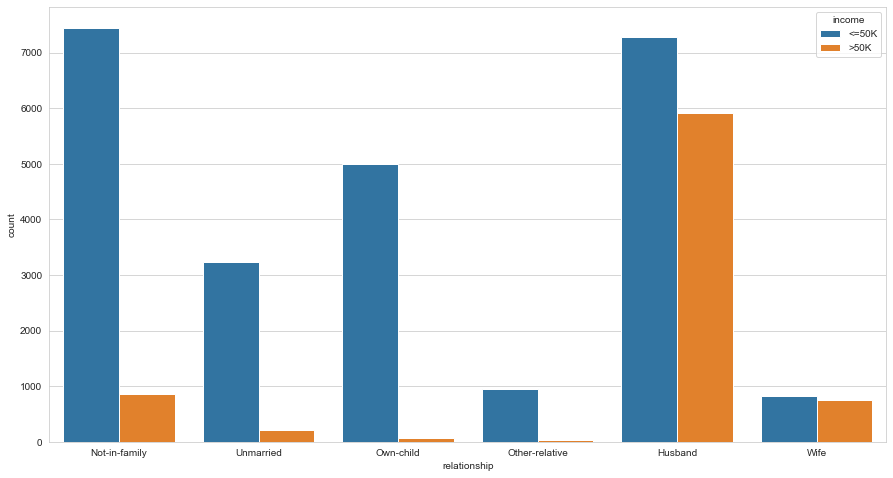

In [17]:
plt.figure(figsize=(15,8))
sns.countplot(df['relationship'], hue=df['income']);

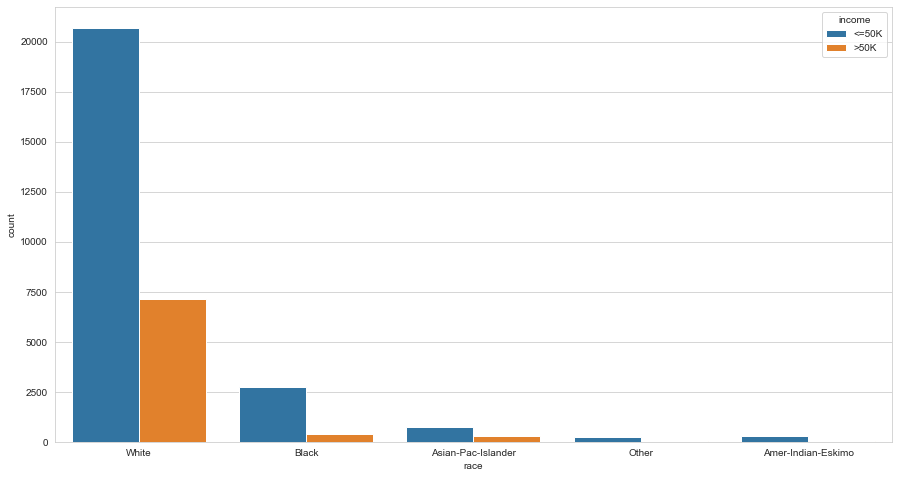

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(df['race'], hue=df['income']);

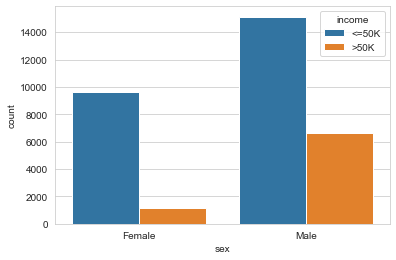

In [19]:
sns.countplot(df['sex'], hue=df['income']);

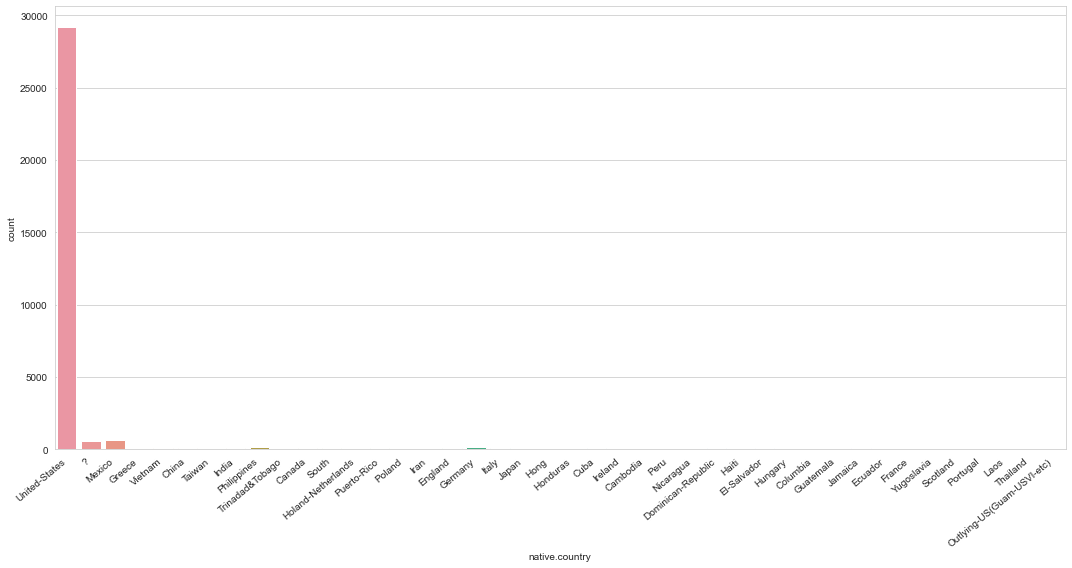

In [20]:
plt.figure(figsize=(15,8))
ax = sns.countplot(df['native.country']);

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### Conclusions

1. workclass, occupations, and native.country have missing values denoted as '?'
2. Need to check if education is correlated to numeric feature 'education.num'
3. Will need to see if native.country has any predictive power

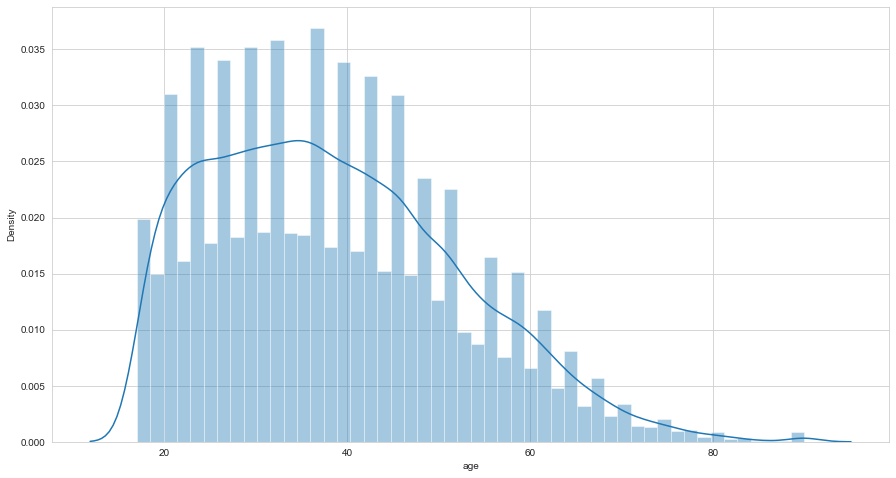

In [21]:
plt.figure(figsize=(15,8))
sns.distplot(df['age']);

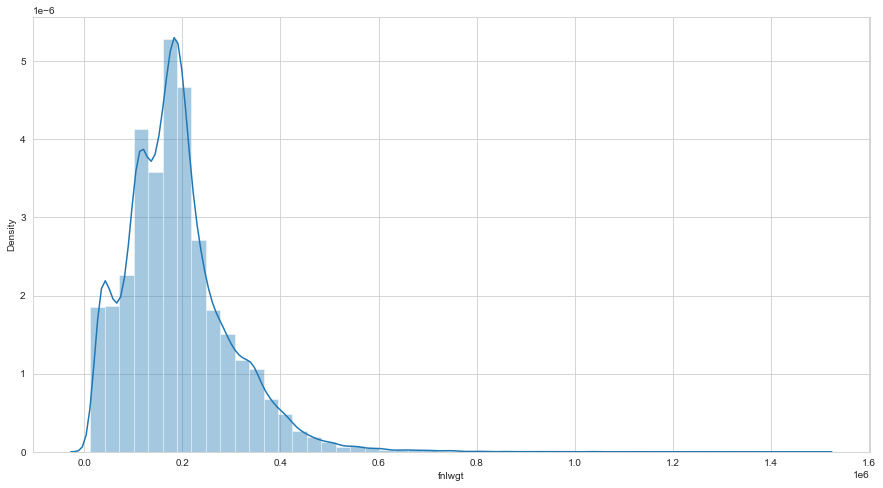

In [22]:
plt.figure(figsize=(15,8))
sns.distplot(df['fnlwgt']);

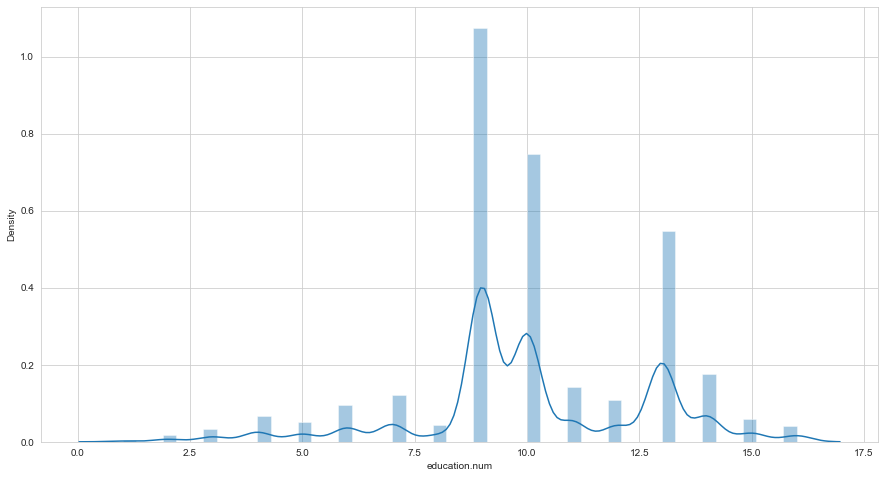

In [23]:
plt.figure(figsize=(15,8))
sns.distplot(df['education.num']);

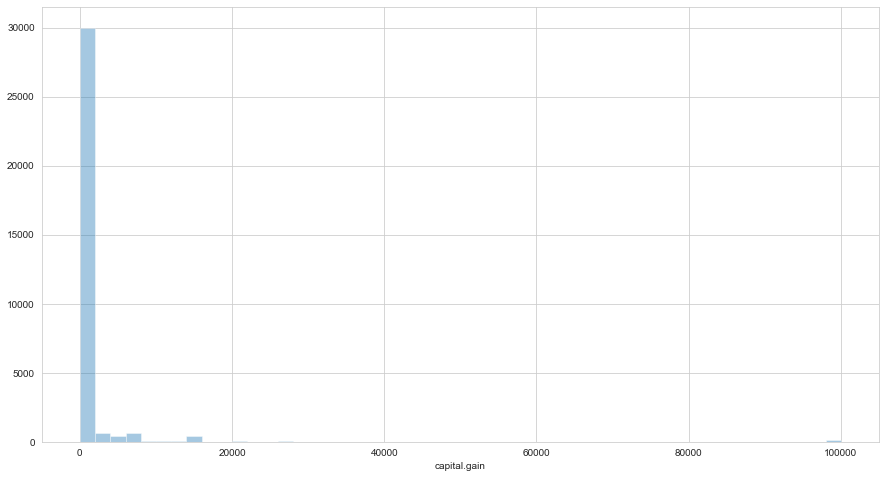

In [24]:
plt.figure(figsize=(15,8))
sns.distplot(df['capital.gain'], kde=False);

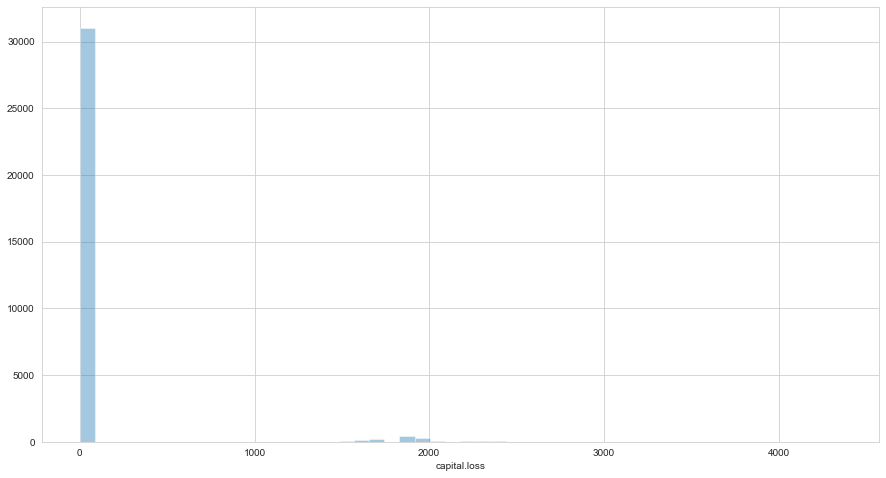

In [25]:
plt.figure(figsize=(15,8))
sns.distplot(df['capital.loss'], kde=False);

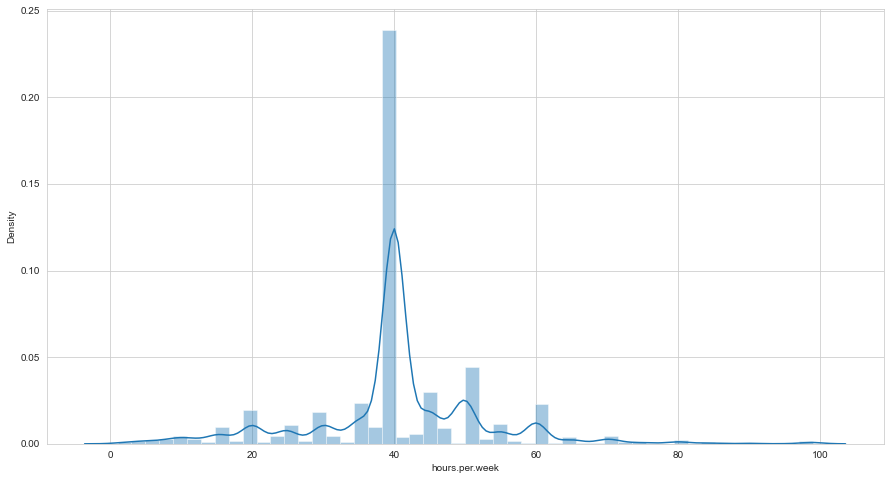

In [26]:
plt.figure(figsize=(15,8))
sns.distplot(df['hours.per.week']);

#### Conclusions

1. age, fnlwgt seems right skewed.
2. education.num is multi-modal, which makes sense.
3. Majority of the values in capital.gain, and capital.loss are 0.
4. hours_per_week seems like normally distributed (although multi-modal), with majority of the people working around 40 hours a week.

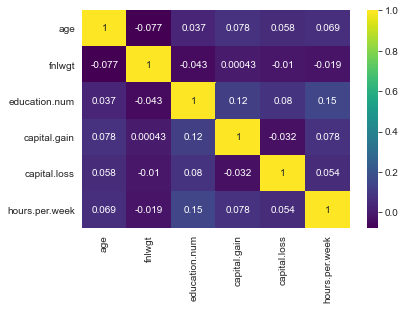

In [27]:
# Checking correlation

sns.heatmap(df.corr(), annot=True, cmap='viridis');

# 5. Feature Selection and Engineering

In [28]:
# Number of '?' in the dataset

for col in df.columns:
    print(col,':', df[df[col] == '?'][col].count())

age : 0
workclass : 1836
fnlwgt : 0
education : 0
education.num : 0
marital.status : 0
occupation : 1843
relationship : 0
race : 0
sex : 0
capital.gain : 0
capital.loss : 0
hours.per.week : 0
native.country : 583
income : 0


Instead of dropping the rows with seemingly missing values '?', I'll just rename it to 'Unknown', that way, if there is unseen data which the model sees with '?', it can help predict with better accuracy.

In [29]:
for cols in df.select_dtypes(exclude=np.number).columns:
    df[cols] = df[cols].str.replace('?', 'Unknown')

In [30]:
# Unique values in each categorical feature

for cols in df.select_dtypes(exclude=np.number).columns:
    print(cols, ':', df[cols].unique(), end='\n\n')

workclass : ['Unknown' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc'
 'Self-emp-inc' 'Local-gov' 'Without-pay' 'Never-worked']

education : ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']

marital.status : ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']

occupation : ['Unknown' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

relationship : ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']

race : ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']

sex : ['Female' 'Male']

native.country : ['United-States' 'Unknown' 'Mexico' 'Greece' 'Vietnam' 'China' 'Taiwan'
 

In [31]:
# Checking for correlation between columns 'education' and 'education-num'

pd.crosstab(df['education.num'],df['education'])

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
education.num,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0
2,0,0,0,168,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,333,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,646,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,514,0,0,0,0,0,0,0,0,0
6,933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1175,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,433,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,10501,0,0,0,0


We can clearly see that categorical feature 'education' can perfectly be described numeric feature 'education.num'. Hence, we can drop one column.

Majority of the values in native.country seem to be USA. Let's find out percentage

In [32]:
df['native.country'].value_counts(normalize=True)*100

United-States                 89.585701
Mexico                         1.974755
Unknown                        1.790486
Philippines                    0.608089
Germany                        0.420749
Canada                         0.371610
Puerto-Rico                    0.350112
El-Salvador                    0.325543
India                          0.307116
Cuba                           0.291760
England                        0.276404
Jamaica                        0.248764
South                          0.245693
China                          0.230337
Italy                          0.224195
Dominican-Republic             0.214981
Vietnam                        0.205768
Guatemala                      0.196554
Japan                          0.190412
Poland                         0.184270
Columbia                       0.181198
Taiwan                         0.156629
Haiti                          0.135131
Iran                           0.132060
Portugal                       0.113633


Let's drop columns. We will drop - 
1. fnlwgt - seems exactly like ID column, so basically useless
2. native.country - almost 90% observations are from one country. Seems useless to me
3. capital.gain - majority of the values are 0
4. capital.loss - same as above
5. education - as this can be described by education.num

In [33]:
df.drop(['fnlwgt', 'capital.gain', 'capital.loss', 'native.country', 'education'], axis=1, inplace=True)

In [34]:
# Dropping rows with hours.per.week = 99

df.drop(df[df['hours.per.week'] == 99].index, inplace=True)

In [35]:
# Converting values in target column to numbers

df['income'] = df['income'].map({'<=50K':0, '>50K':1})

In [36]:
# Encoding categorical features

categorical_columns = df.select_dtypes(exclude=np.number).columns
new_df = pd.get_dummies(data=df, prefix=categorical_columns, drop_first=True)

In [37]:
new_df.shape

(32476, 42)

In [38]:
pd.set_option('max_columns', 50)
new_df.head()

,age,education.num,hours.per.week,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,90,9,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,82,9,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,66,10,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,54,4,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,41,10,40,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


# 6. Modelling + Algorithm Tuning

In [39]:
X = new_df.drop('income', axis=1)
y = new_df['income']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [41]:
# Hyperparameter tuning of Logistic Regression

param_grid = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'solver':['lbfgs', 'liblinear'], 'l1_ratio':[0.001, 0.01, 0.1]}

grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, verbose=3)

grid.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear ...........
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear, score=0.756, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear ...........
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear, score=0.758, total=   0.1s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear ...........
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear, score=0.758, total=   0.1s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear ...........
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear, score=0.758, total=   0.1s
[CV] C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear ...........
[CV]  C=0.001, l1_ratio=0.001, penalty=l1, solver=liblinear, score=0.756, total=   0.1s
[CV] C=0.001, l1_ratio=0.001, penalty=l2, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l2, solver=lbfgs, score=0.840, total=   0.5s
[CV] C=0.001, l1_ratio=0.001, penalty=l2, solver=lbfgs ...............
[CV]  C=0.001, l1_ratio=0.001, penalty=l2, solver=lbfgs, score=0.813, total=   0.5s
[CV] C=0.001, l1_ratio=0.001, penalty=l2, solver=lbfg

KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
log_reg = LogisticRegression(C=1, l1_ratio=0.001, solver='lbfgs', penalty='l2')

In [ ]:
# Hyperparameter tuning of Random Forest

param_grid = {'criterion':['gini', 'entropy'], 'max_depth':[2, 4, 5, 7, 9, 10], 'n_estimators':[100, 200, 300, 400, 500]}

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=3)

grid.fit(X, y)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100, criterion='gini')

In [ ]:
# Hyperparameter tuning of XGBoost

param_grid = {'max_depth':[2, 4, 5, 7, 9, 10], 'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3], 'min_child_weight':[2, 4, 5, 6, 7]}

grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, verbose=3)

grid.fit(X, y)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
xgb = XGBClassifier(learning_rate=0.2, max_depth=4, min_child_weight=2)

In [ ]:
# Hyperparameter tuning of CatBoost

param_grid = {'depth':[2, 4, 5, 7, 9, 10], 'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3], 'iterations':[30, 50, 100]}

grid = GridSearchCV(CatBoostClassifier(), param_grid, verbose=3)

grid.fit(X, y)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
cb = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, verbose=False)

Now, I can directly fit the model on training data, and then make predictions. However, I want to try different approach wherein I choose optimal hyperparameters, and train and predict on folds. Reason behind using this is, model
on each fold will be better and could give a better score when we blend them.

Basically, training models on fold is done for two purposes:
1. to calculate average models
2. to train several models, predict with each of them and average their predictions. This makes the result more stable & robust

The below code is referenced from __[artgor's work](https://www.kaggle.com/artgor/bayesian-optimization-for-robots)__ (shoutout to him)


In [ ]:
classifiers = [log_reg, rfc, xgb, cb]

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

scores_dict = {}

for train_index, valid_index in folds.split(X_train, y_train):
    # Need to use iloc as it provides integer-location based indexing, regardless of index values.
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
    
    for classifier in classifiers:
        name = classifier.__class__.__name__
        classifier.fit(X_train_fold, y_train_fold)
        training_predictions = classifier.predict_proba(X_valid_fold)
        # roc_auc_score should be calculated on probabilities, hence using predict_proba
        
        scores = roc_auc_score(y_valid_fold, training_predictions[:, 1])
        if name in scores_dict:
            scores_dict[name] += scores
        else:
            scores_dict[name] = scores

# Taking average of the scores
for classifier in scores_dict:
    scores_dict[classifier] = scores_dict[classifier]/folds.n_splits

In [ ]:
scores_dict

# 7. Finalising the Model + Prediction

Clearly from the above scores dictionary, we can see that XGBoost fares better than the rest. Hence we will use the same, and predict our data

In [ ]:
final_predictions = xgb.predict_proba(X_test)

print(roc_auc_score(y_test, final_predictions[:, 1]))

## Fairness

In [42]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [43]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [44]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [45]:
new_df.head()

,age,education.num,hours.per.week,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,90,9,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,82,9,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,66,10,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,54,4,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,41,10,40,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [46]:
#print(X)


#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'sex_Male': 1}]
unprivileged_groups = [{'sex_Male': 0}]
dataset_orig = StandardDataset(new_df,
                                  label_name='income',
                                  protected_attribute_names=['sex_Male'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])

#metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
#                                             unprivileged_groups=unprivileged_groups,
#                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


In [47]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.196000


In [48]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = XGBClassifier(learning_rate=0.2, max_depth=4, min_child_weight=2,n_estimators= 1)

mdl = model.fit(X_train, y_train)
with open('../../Results/XGBoost/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/XGBoost/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/XGBoost/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [49]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = XGBClassifier(learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators= i)
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [50]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
#print(final_result)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/XGBoost/' + nb_fname + '.csv')
final_result

,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,...,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.846454,0.818434,0.820794,0.820897,0.825926,0.827055,0.829211,0.828492,0.828903,0.828390,0.829827,0.830442,0.831982,0.831879,0.833829,0.834445,0.834856,0.835574,0.835985,0.835780,0.837114,0.838140,0.838756,0.839064,0.838551,...,0.845427,0.844914,0.844606,0.845530,0.845633,0.845735,0.845120,0.845427,0.845530,0.845633,0.845941,0.845735,0.845838,0.845838,0.845633,0.845633,0.845838,0.846146,0.846043,0.845941,0.845838,0.845530,0.845941,0.845838,0.846454
f1,0.641247,0.501550,0.513378,0.513521,0.552978,0.566727,0.557447,0.556175,0.560274,0.570621,0.578117,0.578141,0.578636,0.579137,0.588982,0.586940,0.586694,0.591118,0.591095,0.594937,0.596901,0.601466,0.602781,0.604839,0.603878,...,0.636232,0.634583,0.633946,0.636912,0.637241,0.637569,0.636122,0.637632,0.637611,0.637939,0.638575,0.638267,0.638769,0.638769,0.638114,0.638114,0.638421,0.639230,0.639076,0.639616,0.639462,0.638829,0.639962,0.639635,0.641247
statistical_parity_difference,-0.179284,-0.131838,-0.130397,-0.130707,-0.156881,-0.165881,-0.149812,-0.155681,-0.154102,-0.175460,-0.179124,-0.177905,-0.174080,-0.175153,-0.175403,-0.166943,-0.163248,-0.168936,-0.162765,-0.170132,-0.169067,-0.172133,-0.170435,-0.171965,-0.171497,...,-0.177930,-0.176236,-0.175926,-0.176842,-0.176995,-0.177148,-0.177148,-0.177601,-0.177605,-0.177294,-0.177605,-0.177447,-0.177444,-0.177444,-0.177137,-0.178528,-0.177758,-0.177911,-0.178065,-0.179445,-0.179134,-0.179287,-0.179130,-0.178977,-0.179284
equal_opportunity_difference,-0.132988,-0.151533,-0.127273,-0.127273,-0.166085,-0.169821,-0.152192,-0.181786,-0.156019,-0.211228,-0.214000,-0.211951,-0.207852,-0.209389,-0.189498,-0.162255,-0.156861,-0.175093,-0.150140,-0.163731,-0.170422,-0.178106,-0.172440,-0.173193,-0.169336,...,-0.136122,-0.130216,-0.126358,-0.127624,-0.128136,-0.128648,-0.127112,-0.126840,-0.126328,-0.126840,-0.124007,-0.124007,-0.125032,-0.125032,-0.127352,-0.134043,-0.127352,-0.128377,-0.128377,-0.130426,-0.130426,-0.133259,-0.131451,-0.130939,-0.132988
average_abs_odds_difference,0.105818,0.104283,0.091893,0.092067,0.118982,0.124026,0.108425,0.124446,0.112198,0.146562,0.148867,0.147316,0.143318,0.144524,0.134976,0.118882,0.114458,0.124843,0.110749,0.120236,0.122158,0.126548,0.122993,0.123917,0.122142,...,0.107143,0.103906,0.102196,0.102829,0.103085,0.103341,0.102901,0.102810,0.102618,0.102591,0.101523,0.101458,0.101796,0.101796,0.102673,0.106301,0.103021,0.103424,0.103534,0.105105,0.104931,0.106282,0.105269,0.105013,0.105818
disparate_impact,-1.255830,-1.468726,-1.370450,-1.377467,-1.454245,-1.439526,-1.399725,-1.484148,-1.416283,-1.577865,-1.572966,-1.578125,-1.571604,-1.576477,-1.501292,-1.430741,-1.396104,-1.439784,-1.368350,-1.410017,-1.413860,-1.427493,-1.407105,-1.409621,-1.399184,...,-1.272570,-1.259289,-1.254855,-1.255412,-1.256032,-1.256651,-1.256651,-1.252204,-1.255347,-1.250970,-1.255347,-1.251587,-1.248463,-1.248463,-1.247230,-1.262208,-1.255964,-1.256580,-1.257197,-1.262727,-1.258350,-1.258963,-1.255218,-1.254606,-1.255830
theil_index,0.124893,0.171822,0.168359,0.168321,0.155797,0.150946,0.154730,0.155067,0.153671,0.149736,0.147147,0.147277,0.147425,0.147209,0.143788,0.144748,0.144940,0.143364,0.143473,0.141878,0.141426,0.139833,0.139458,0.138690,0.138947,...,0.126882,0.127463,0.127646,0.126600,0.126484,0.126368,0.126816,0.126219,0.126268,0.126152,0.125970,0.126036,0.125837,0.125837,0.126069,0.126069,0.126003,0.125738,0.125771,0.125472,0.125505,0.125688,0.125307,0.125423,0.124893
